# Shot Boundery Detection by VGG16 vetcor Cloustering

In [49]:
import os
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from progressbar import progressbar
import warnings
warnings.filterwarnings('ignore')
from natsort import natsorted, ns

def show(img):
    plt.imshow(img)
    plt.show()

In [33]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [34]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

In [35]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Some sample prediction

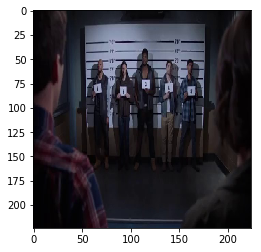

(1, 7, 7, 512)


In [36]:
img_path = 'data/image_0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = model.predict(img_data)

show(img)
print(vgg16_feature.shape)

## Predict for all images

In [37]:
!pip install joblib

In [84]:
# define model
model_vgg16 = model

# define input
filenames = os.listdir('./data/')[::1]

# define prediction function
def vgg16Pred(fname):
    try:
        img = image.load_img('data/'+fname, target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)

        vgg16_feature = model_vgg16.predict(img_data)
        vgg16_feature_np = np.array(vgg16_feature)

        return vgg16_feature_np.flatten()
    except: pass
    
num_cores = multiprocessing.cpu_count()
vgg16_feature_list = Parallel(n_jobs=num_cores)(delayed(vgg16Pred)(fname) for fname in progressbar(filenames))

vgg16_feature_list_np = np.array(vgg16_feature_list)
vgg16_feature_list_np.shape

100% (275 of 275) |######################| Elapsed Time: 0:09:29 Time:  0:09:29


(275, 25088)

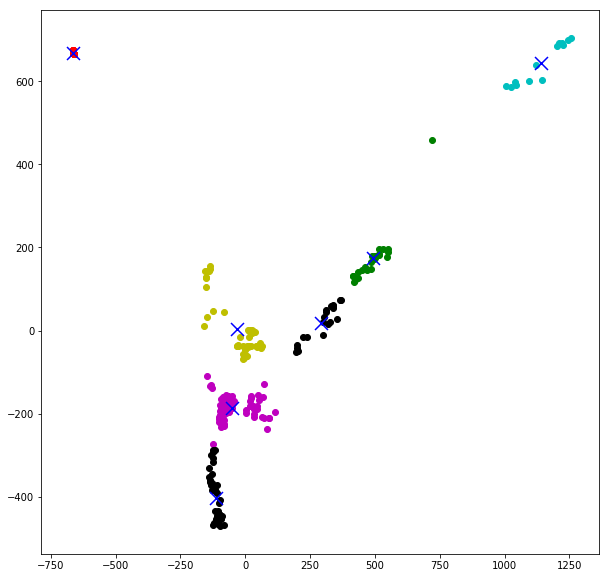

In [100]:
n_digits=7
data = vgg16_feature_list_np
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.figure(figsize=(10,10))

c = ['g','r','c','m','y','k']

for i in range(len(reduced_data)):
    plt.scatter(reduced_data[i][0], reduced_data[i][1], c=c[kmeans.labels_[i]-1])

plt.scatter(centroids[:,0], centroids[:,1],  marker='x', s=169, linewidths=3, color='b', zorder=1)

plt.show()

In [92]:
n_digits=7
data = vgg16_feature_list_np
reduced_data = data
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(labels)

[6 2 2 1 5 0 1 1 1 1 2 4 0 1 6 1 5 2 4 6 1 2 4 1 5 6 6 4 1 1 5 1 4 4 1 1 1
 1 1 1 6 4 1 5 6 6 5 6 2 1 1 6 1 5 6 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 0 6 1 1
 6 1 3 1 0 4 1 5 6 1 4 1 6 1 5 1 1 1 1 1 4 1 1 1 1 0 6 1 1 1 1 6 1 1 1 1 2
 1 1 1 1 1 5 5 1 6 1 1 1 5 2 1 0 6 1 1 0 1 4 6 1 4 1 1 5 0 1 1 5 2 3 1 6 3
 1 5 1 6 1 4 6 6 1 5 2 1 1 4 6 1 3 2 1 1 1 1 5 0 1 5 0 5 1 1 1 5 1 1 6 1 6
 0 1 1 0 5 1 5 1 1 5 6 1 5 6 4 1 6 0 1 0 3 1 1 6 1 6 6 2 1 6 2 4 4 1 5 6 3
 1 6 1 0 5 6 1 4 6 1 1 6 4 4 5 1 1 5 5 4 4 4 6 1 0 6 1 1 6 1 3 0 6 1 6 1 1
 1 4 1 5 1 1 1 1 0 1 5 1 1 5 2 1]


## Set of classes

In [93]:
scenes = {i:[] for i in range(n_digits)}
for i, label in enumerate(labels):
    try: scenes[label] += [filenames[i]]
    except: continue

## Sort by file name

In [94]:
for label in scenes:
    scenes[label] = natsorted(scenes[label], alg=ns.IGNORECASE)

## Some classes smaple

label #0 18
label #1 135
label #2 14
label #3 7
label #4 24
label #5 33
label #6 44


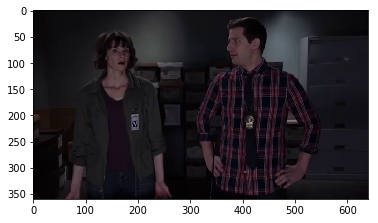

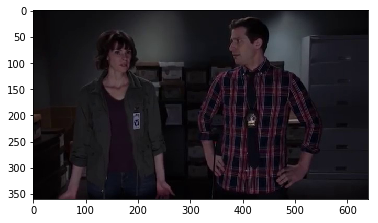

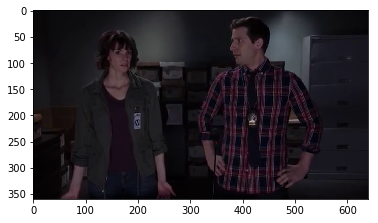

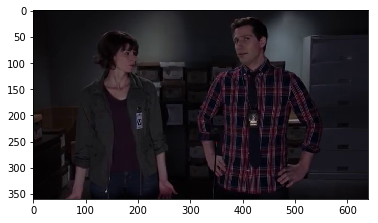

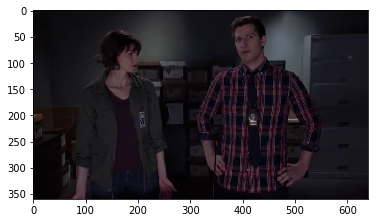

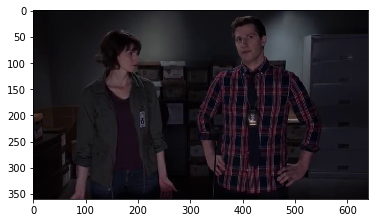

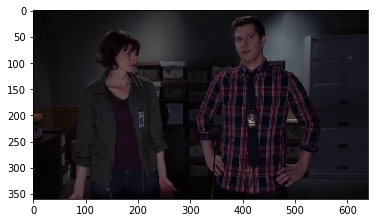

In [98]:
for label in scenes:
    print('label #'+str(label), len(scenes[label]))

classNumber = 1
for s in scenes[classNumber][:7]:
    show(image.load_img('./data/'+s))

# Main Scenes

./data/image_0.jpg


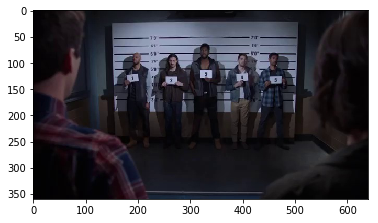

./data/image_55.jpg


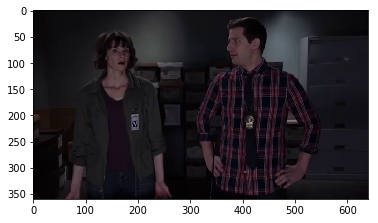

./data/image_429.jpg


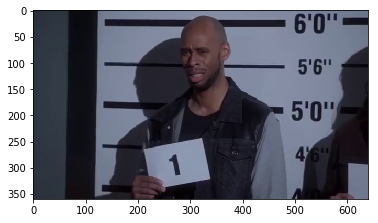

./data/image_1287.jpg


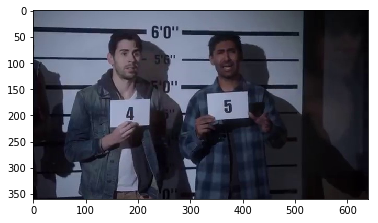

./data/image_1650.jpg


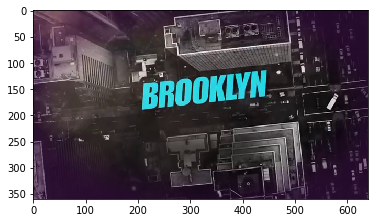

./data/image_1748.jpg


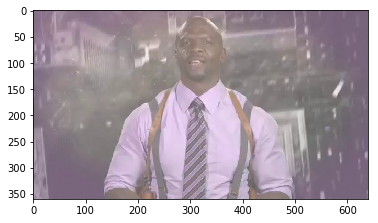

./data/image_1859.jpg


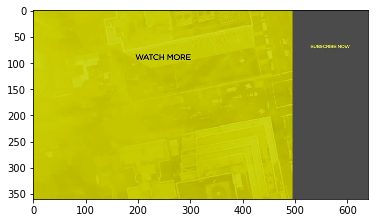

In [103]:
sorted_scenes = []

for label in scenes:
    try: sorted_scenes += ['./data/'+scenes[label][0]]
    except:continue

for fname in natsorted(sorted_scenes, alg=ns.IGNORECASE):
    try:
        print(fname)
        show(image.load_img(fname))
    except:continue